In [12]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from progressbar import ProgressBar
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as BE
from Integrated_Gradients_algorithm import *


import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "4"
config=tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.compat.v1.Session(config=config)     

In [13]:
import keras
def get_loss_gradients(img_input, model, target_one_hot, from_logits=False):
    images = tf.cast(img_input, tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=from_logits)
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        loss = cce(target_one_hot, preds)
#         top_class = preds[:, top_pred_idx]

    grads = tape.gradient(loss, images)
    return grads

In [2]:
def get_acc(predict_label, ground_truth=None):
    for i in predict_label[0]:
        if i[0] == ground_truth:
            return True
    return False

def softmax( f ):
    # instead: first shift the values of f so that the highest number is 0:
    f -= np.max(f) # f becomes [-666, -333, 0]
    return np.exp(f) / np.sum(np.exp(f))  # safe to do, gives the correct answer

def get_APFD(Gini_indexs, ground_truth_label, predicted_confidence, top_set=None):
    o_i = 0
    pbar = ProgressBar()
    wrong_num = 0
    for i in pbar(range(0, len(Gini_indexs))):
        if top_set is not None:
            if not get_acc(predict_label=decode_predictions(predicted_confidence[Gini_indexs[i]], top=top_set), 
                           ground_truth=ground_truth_label[Gini_indexs[i]]):
                o_i = o_i+i
#                 print(i, o_i)
                wrong_num = wrong_num+1
        else:
            if np.argmax(ground_truth_label[Gini_indexs[i]]) != np.argmax(predicted_confidence[Gini_indexs[i]]):
                o_i = o_i+i
                wrong_num = wrong_num+1
    APFD = 1 - o_i/(len(Gini_indexs)*wrong_num) + 1/(2*len(Gini_indexs))
    return APFD, len(Gini_indexs), wrong_num

def get_RAUC(Gini_indexs, ground_truth_label, predicted_confidence, top_set=None):
    pre_y_axis = []
    o_i = 0
    wrong_num = 0
    pbar = ProgressBar()
    for i in pbar(range(0, len(Gini_indexs))):
        if top_set is not None:
            if not get_acc(predict_label=decode_predictions(predicted_confidence[Gini_indexs[i]], top=top_set), 
                           ground_truth=ground_truth_label[Gini_indexs[i]]):  
                o_i = o_i+1
                wrong_num = wrong_num+1
                pre_y_axis.append(o_i)
            else:
                pre_y_axis.append(o_i)
        else:
            if np.argmax(ground_truth_label[Gini_indexs[i]]) != np.argmax(predicted_confidence[Gini_indexs[i]]):
                o_i = o_i+1
                wrong_num = wrong_num+1
                pre_y_axis.append(o_i)
            else:
                pre_y_axis.append(o_i)
    true_y_axis = wrong_num*(len(Gini_indexs)-wrong_num) + (wrong_num+1)*wrong_num/2
    RAUC = np.sum(pre_y_axis)/true_y_axis
#     print("RAUC: ", RAUC)
    return RAUC, len(Gini_indexs), wrong_num

In [3]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train = np.reshape(X_train,[-1,28*28])/255.0
X_test = np.reshape(X_test,[-1,28*28])/255.0
Y_train = to_categorical(Y_train,10)
Y_test = to_categorical(Y_test,10)

In [4]:
input_shape = 28*28

model = Sequential()
model.add(Dense(input_shape=(input_shape,), units=input_shape, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # model training
# model.fit(X_train, Y_train, epochs=10, batch_size=512)

# MODEL_PATH = "/public/liujiawei/huawei/ZHB/ADF-master/models/"
# model.save(MODEL_PATH+"fmnist_FC5_good.h5")

# del model

In [5]:
MODEL_PATH = "/public/liujiawei/huawei/ZHB/ADF-master/models/"
model = load_model(MODEL_PATH+"fmnist_FC5_good.h5")

In [6]:
loss_acc = model.evaluate(X_test, Y_test, batch_size=128)
print('accuracy', loss_acc[-1])

79/79 [==============================] - 4s 17ms/step - loss: 0.3493 - accuracy: 0.8772
accuracy 0.8772000074386597


In [7]:
# # adversarial attack
# from tensorflow.keras import backend as BE

# max_iter = 5e+2
# examples_num1 = 1000
# decay_factor_gradent = 0.9
# max_iter = 100
# epsilon_lr = 1.0/max_iter*2
# # decay_factor_epsilon_lr = 0.99

# # x_GE = np.zeros((1, 28*28))
# # per_tmp = model.predict(x_GE)
# # label_tmp = np.argmax(per_tmp)

# # grads = BE.gradients(loss = BE.categorical_crossentropy([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1], model.layers[-1].output[:,:]), variables = model.inputs)
# # grads = BE.gradients(loss = model.layers[-1].output[:,label_tmp], variables = model.inputs)
# # get_gradients = BE.function(inputs=model.inputs[0], outputs=grads)

# x_adv = []
# X_test_part = X_test[0:examples_num1]
# Y_test_part = Y_test[0:examples_num1]

# for i1, x_tmp in enumerate(X_test_part):
#     x_tmp = x_tmp.reshape(-1,28*28)
#     y_tmp = Y_test_part[i1]
#     x_append = x_tmp
#     if np.argmax(model.predict(x_tmp)) == np.argmax(y_tmp) :
# #         print(1)
#         # 获取目标攻击的标签
#         y_pre_tmp = model.predict(x_tmp)
#         target_label = np.argsort(-y_pre_tmp) 
#         target_label = target_label[:,1][0]  # 置信度第二高的标签，作为目标标签
        
#         # 计算目标攻击的对抗样本
#         grads = BE.gradients(loss = model.layers[-1].output[:,target_label], variables = model.inputs)
#         get_gradients = BE.function(inputs=model.inputs[0], outputs=grads)
#         x_moment = 0
#         print("process:{}%".format(i1/examples_num1*100))
#         for iter1 in range(0, max_iter):
#             x_grad = get_gradients(x_tmp)[0]  #获取梯度
#             x_moment = x_moment * decay_factor_gradent + x_grad  #计算动量
#     #         epsilon_lr = epsilon_lr * decay_factor_epsilon_lr # 扰动衰减
#             x_tmp = x_tmp + x_moment * epsilon_lr # 添加扰动
#             x_tmp = np.clip(x_tmp, 0, 1)

#     #         print(np.argmax(model.predict(x_tmp)), np.argmax(y_tmp))
#             if np.argmax(model.predict(x_tmp)) != np.argmax(y_tmp) : # 判断是否成为对抗样本
#                 x_append = x_tmp
#                 print("succeed!")
#                 break
                
#     x_adv.append(x_append)

# X_adv = np.reshape(x_adv, [-1,28*28])
# Y_adv = Y_test_part

In [7]:
DATA_PATH = '/public/liujiawei/huawei/ZHB/ADF-master/mnist/'

# # 保存对抗样本
# np.save(DATA_PATH + 'fmnist_Xadv1000.npy', X_adv)
# np.save(DATA_PATH + 'fmnist_Yadv_true1000.npy', Y_adv)

# 导入对抗样本
X_adv = np.load(DATA_PATH + 'fmnist_Xadv1000.npy')
Y_adv = np.load(DATA_PATH + 'fmnist_Yadv_true1000.npy')

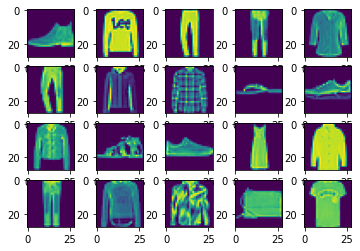

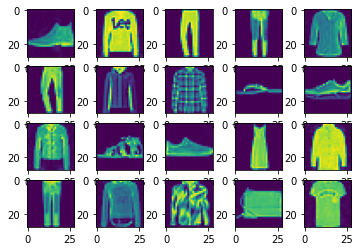

In [8]:
# 可视化正常样本和对抗样本

plt.figure()
hang = 4
lie = 5
for i in range(0,hang):
    for j in range(0,lie):
        plt.subplot(hang,lie,i*lie+j+1)
        plt.imshow(X_test[i*lie+j].reshape((28,28,1)))
#         print(np.argmax(model.predict(X_test_part[i*lie+j].reshape(-1, 28*28))))
        
plt.figure()
hang = 4
lie = 5
for i in range(0,hang):
    for j in range(0,lie):
        plt.subplot(hang,lie,i*lie+j+1)
        plt.imshow(X_adv[i*lie+j].reshape((28,28,1)))
#         print(np.argmax(model.predict(X_adv[i*lie+j].reshape(-1, 28*28))))

In [9]:
# 检查数据是否有问题
loss_acc = model.evaluate(X_adv, Y_adv)
print(np.shape(X_adv))

32/32 [==============================] - 1s 11ms/step - loss: 0.7836 - accuracy: 0.4090
(1000, 784)


In [10]:
Gini = []
predicted_confidence = []
pbar = ProgressBar()
for x_tmp in pbar(X_adv):
    per_tmp = model.predict(x_tmp.reshape([-1,28*28]))
    label_tmp = np.argmax(per_tmp)
    Gini_tmp = 1-np.sum(per_tmp*per_tmp)
#     Gini_tmp = -np.sum(per_tmp*np.log2(per_tmp))
    Gini.append(Gini_tmp)
    predicted_confidence.append(per_tmp)
    
indexs = np.argsort(Gini)
indexs = indexs[::-1]
APFD,_,_ = get_APFD(Gini_indexs=indexs, ground_truth_label=Y_adv, 
                predicted_confidence=np.array(predicted_confidence))
print('APFD:', APFD)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=Y_adv, 
                predicted_confidence=np.array(predicted_confidence))
print('RAUC:', RAUC)


100% |########################################################################|
100% |########################################################################|


APFD: 0.7053274111675126
RAUC: 0.9997551931454081


In [17]:
# Gini = []
# index1 = 0
# index2 = 0
# pbar = ProgressBar()
# for x_tmp in pbar(X_adv):
#     per_tmp = model.predict(x_tmp.reshape([-1,28*28]))
#     label_tmp = np.argmax(per_tmp)
#     if label_tmp == np.argmax(Y_adv[index1]):
#         index2 = index2 +1
#     index1 = index1 + 1
#     Gini_tmp = 1-np.sum(per_tmp*per_tmp)
# #     Gini_tmp = -np.sum(per_tmp*np.log2(per_tmp))
#     Gini.append(Gini_tmp)
    
# indexs = np.argsort(Gini)
# indexs = indexs[::-1]

# pbar = ProgressBar()
# o_i = 0
# for i in pbar(range(0, (index1))):
#     x_tmp = X_adv[indexs[i]].reshape([-1,28*28])
#     y_tmp = Y_adv[indexs[i]]
#     per_tmp = model.predict(x_tmp)
#     if np.argmax(y_tmp)!=np.argmax(per_tmp):
#         o_i = o_i+i
# APFD = 1-o_i/(index1*(index1-index2))+1/(2*index1)
# print(APFD)

In [14]:
# use one layer's activation
pbar = ProgressBar()
# layer_pos = -2
# get_activations = BE.function(inputs=model.inputs[0], outputs=model.layers[layer_pos].output[:,:])
grads_pre1 = []
grads_pre2 = []
grads_CE = []
grads_CE2 = []
num_class = 10
# predicted_confidence = []
# ground_truth_label = []
for x_tmp in pbar(X_adv):
    x_tmp = x_tmp.reshape([-1,28*28])
    preds = model.predict(x_tmp)
    
    #     使用预测标签当做真实标签验证
    label1 = np.argmax(preds[0])
    grads = get_gradients(img_input=x_tmp, model=model, top_pred_idx=label1)
    grads = np.sum(np.abs(grads))
    grads_pre1.append(grads)
    
    target_one_hot = np.reshape(to_categorical(label1, num_class), (-1, num_class))
    grads = get_loss_gradients(img_input=x_tmp, model=model, target_one_hot=target_one_hot)
    grads = np.sum(np.abs(grads))
    grads_CE.append(grads)
    
    preds[0][label1] = 0
    label2 = np.argmax(preds[0])
    grads = get_gradients(img_input=x_tmp, model=model, top_pred_idx=label2)
    grads = np.sum(np.abs(grads))
    grads_pre2.append(grads)
    
    target_one_hot = np.reshape(to_categorical(label2, num_class), (-1, num_class))
    grads = get_loss_gradients(img_input=x_tmp, model=model, target_one_hot=target_one_hot)
    grads = np.sum(np.abs(grads))
    grads_CE2.append(grads)
    
    
    
#     # 使用attention机制
#     x_act = softmax(get_activations(x_tmp.reshape([-1,28*28])))
#     att1 = np.dot(np.transpose(x_act), x_act)
#     att_weight = np.sum(att1, axis = 1).reshape(np.shape(x_act))
#     x_act_ = softmax(x_act*att_weight)
#     Gini_tmp = 1-np.sum(x_act_*x_act_)
#     Gini_act.append(Gini_tmp)
    
#     predicted_confidence.append(model.predict(x_tmp.reshape([-1,28*28])))
#      # 未使用attention机制
#     x_act = softmax(get_activations(x_tmp.reshape([-1,28*28])))
#     Gini_tmp = 1-np.sum(x_act*x_act)
#     Gini_act.append(Gini_tmp)


100% |########################################################################|


In [38]:
Gini_act =[]
pbar = ProgressBar()
for i in pbar(range(len(grads_CE))):
#     x_act = np.sum(np.abs(grads_CE[i]))
    x_act =[np.sum(np.abs(grads_CE[i])),
            np.sum(np.abs(grads_CE2[i])),
#             np.sum(np.abs(grads_CE_min[i])),
#             np.sum(np.abs(grads_RCE[i])),
#             np.sum(np.abs(grads_CE_ave[i])),
            np.sum(np.abs(grads_pre1[i])),
            np.sum(np.abs(grads_pre2[i])),
#             np.sum(np.abs(grads_pre_min[i]))
           ]
#     print(i,':',x_act)
    Gini_act.append(x_act)
    
Gini_act = np.array(Gini_act)
indexs = np.argsort(1-Gini_act[:,0]/Gini_act[:,1])
# indexs = indexs[::-1]
APFD,_,_ = get_APFD(Gini_indexs=indexs, ground_truth_label=Y_adv, 
                predicted_confidence=np.array(predicted_confidence))
print('APFD:', APFD)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=Y_adv, 
                predicted_confidence=np.array(predicted_confidence))
print('RAUC:', RAUC)

100% |########################################################################|
100% |########################################################################|


APFD: 0.4521311336717428
RAUC: 0.6406115371230394


In [17]:
APFD,_,_ = get_APFD(Gini_indexs=indexs, ground_truth_label=Y_adv, 
                predicted_confidence=np.array(predicted_confidence))
print('APFD:', APFD)

RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=Y_adv, 
                predicted_confidence=np.array(predicted_confidence))
print('RAUC:', RAUC)

100% |########################################################################|


APFD: 0.5934103214890016
RAUC: 0.8410075482113499


In [12]:
# # use all layers' activation
# pbar = ProgressBar()
# get_activations1 = BE.function(inputs=model.inputs[0], outputs=model.layers[-2].output[:,:])
# get_activations2 = BE.function(inputs=model.inputs[0], outputs=model.layers[-3].output[:,:])
# get_activations3 = BE.function(inputs=model.inputs[0], outputs=model.layers[-4].output[:,:])
# Gini_act = []
# for x_tmp in pbar(X_adv):
#     x_act1 = softmax(get_activations1(x_tmp.reshape([-1,28*28])))
#     x_act2 = softmax(get_activations2(x_tmp.reshape([-1,28*28])))
#     x_act3 = softmax(get_activations3(x_tmp.reshape([-1,28*28])))
# #     Gini_tmp = 1-(np.sum(x_act1*x_act1)+np.sum(x_act2*x_act2)+np.sum(x_act3*x_act3))/3   # 基尼系数
# #     Gini_tmp = 1-np.sum(x_act3*x_act3)
#     Gini_tmp = (-np.sum(x_act1*np.log2(x_act1))-np.sum(x_act2*np.log2(x_act2))-np.sum(x_act3*np.log2(x_act3)))/3  # 信息熵
#     Gini_act.append(Gini_tmp)

# # use one layer's activation
# pbar = ProgressBar()
# layer_pos = -2
# get_activations = BE.function(inputs=model.inputs[0], outputs=model.layers[layer_pos].output[:,:])
# Gini_act = []
# for x_tmp in pbar(X_adv):
    
#     # 使用attention机制
#     x_act = softmax(get_activations(x_tmp.reshape([-1,28*28])))
#     att1 = np.dot(np.transpose(x_act), x_act)
#     att_weight = np.sum(att1, axis = 1).reshape(np.shape(x_act))
#     x_act_ = softmax(x_act*att_weight)
#     Gini_tmp = 1-np.sum(x_act_*x_act_)
#     Gini_act.append(Gini_tmp)
    
# #      # 未使用attention机制
# #     x_act = softmax(get_activations(x_tmp.reshape([-1,28*28])))
# #     Gini_tmp = 1-np.sum(x_act*x_act)
# #     Gini_act.append(Gini_tmp)

# indexs = np.argsort(Gini_act)
# indexs = indexs[::-1]
# o_i = 0
# pbar = ProgressBar()
# for i in pbar(range(0, (index1))):
#     x_tmp = X_adv[indexs[i]].reshape([-1,28*28])
#     y_tmp = Y_adv[indexs[i]]
#     per_tmp = model.predict(x_tmp)
#     if np.argmax(y_tmp)!=np.argmax(per_tmp):
#         o_i = o_i+i
# APFD = 1-o_i/(index1*(index1-index2))+1/(2*index1)
# print(APFD)

100% |########################################################################|


0.5934103214890016


In [204]:
APFD 基于基尼系数
# 0.7991785109983078 #使用所有层
# 0.7736928934010152 #倒数第四层
# 0.7608011844331641 #倒数第三层
# 0.7998722504230118 #倒数第二层

APFD 基于信息熵
# 0.7873274111675126 #使用所有层

In [37]:
print(np.shape(x_act))
# print(x_act)
print(np.shape(np.transpose(x_act)))
# print(np.transpose(x_act))

att1 = np.dot(np.transpose(x_act), x_act)

print(np.shape(att1))
# print(att1)

att_weight = np.sum(att1, axis = 1).reshape(np.shape(x_act))
print(np.shape(att_weight))
print(np.shape(x_act))

(1, 64)
(64, 1)


(64, 64)
(1, 64)
(1, 64)
